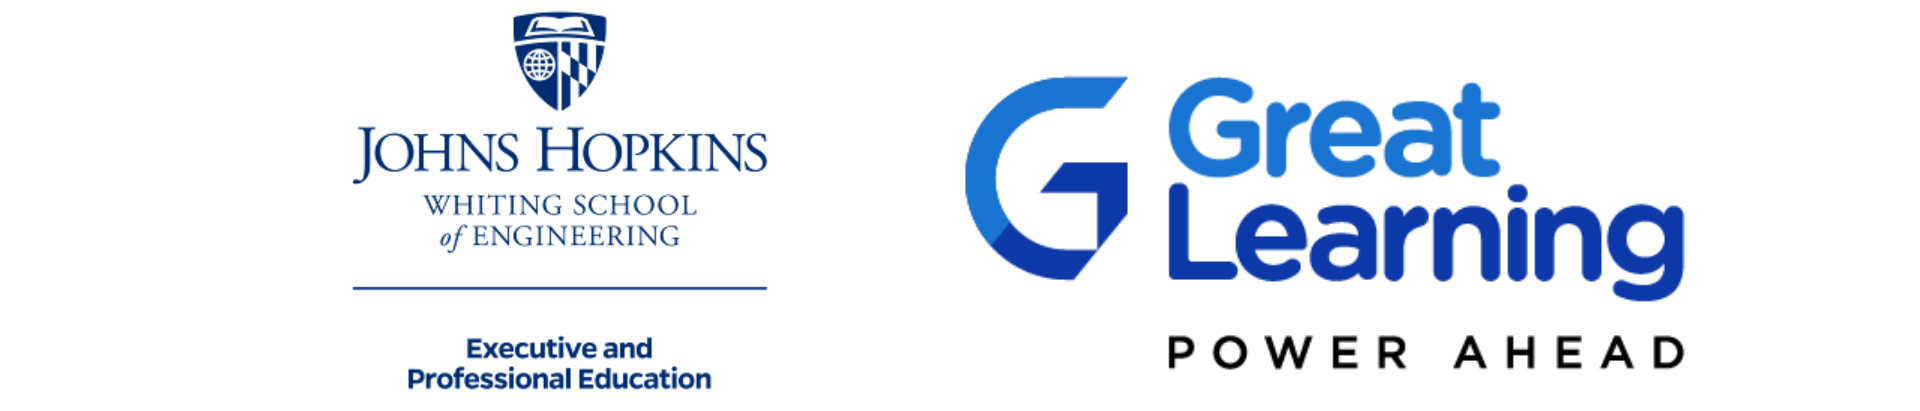

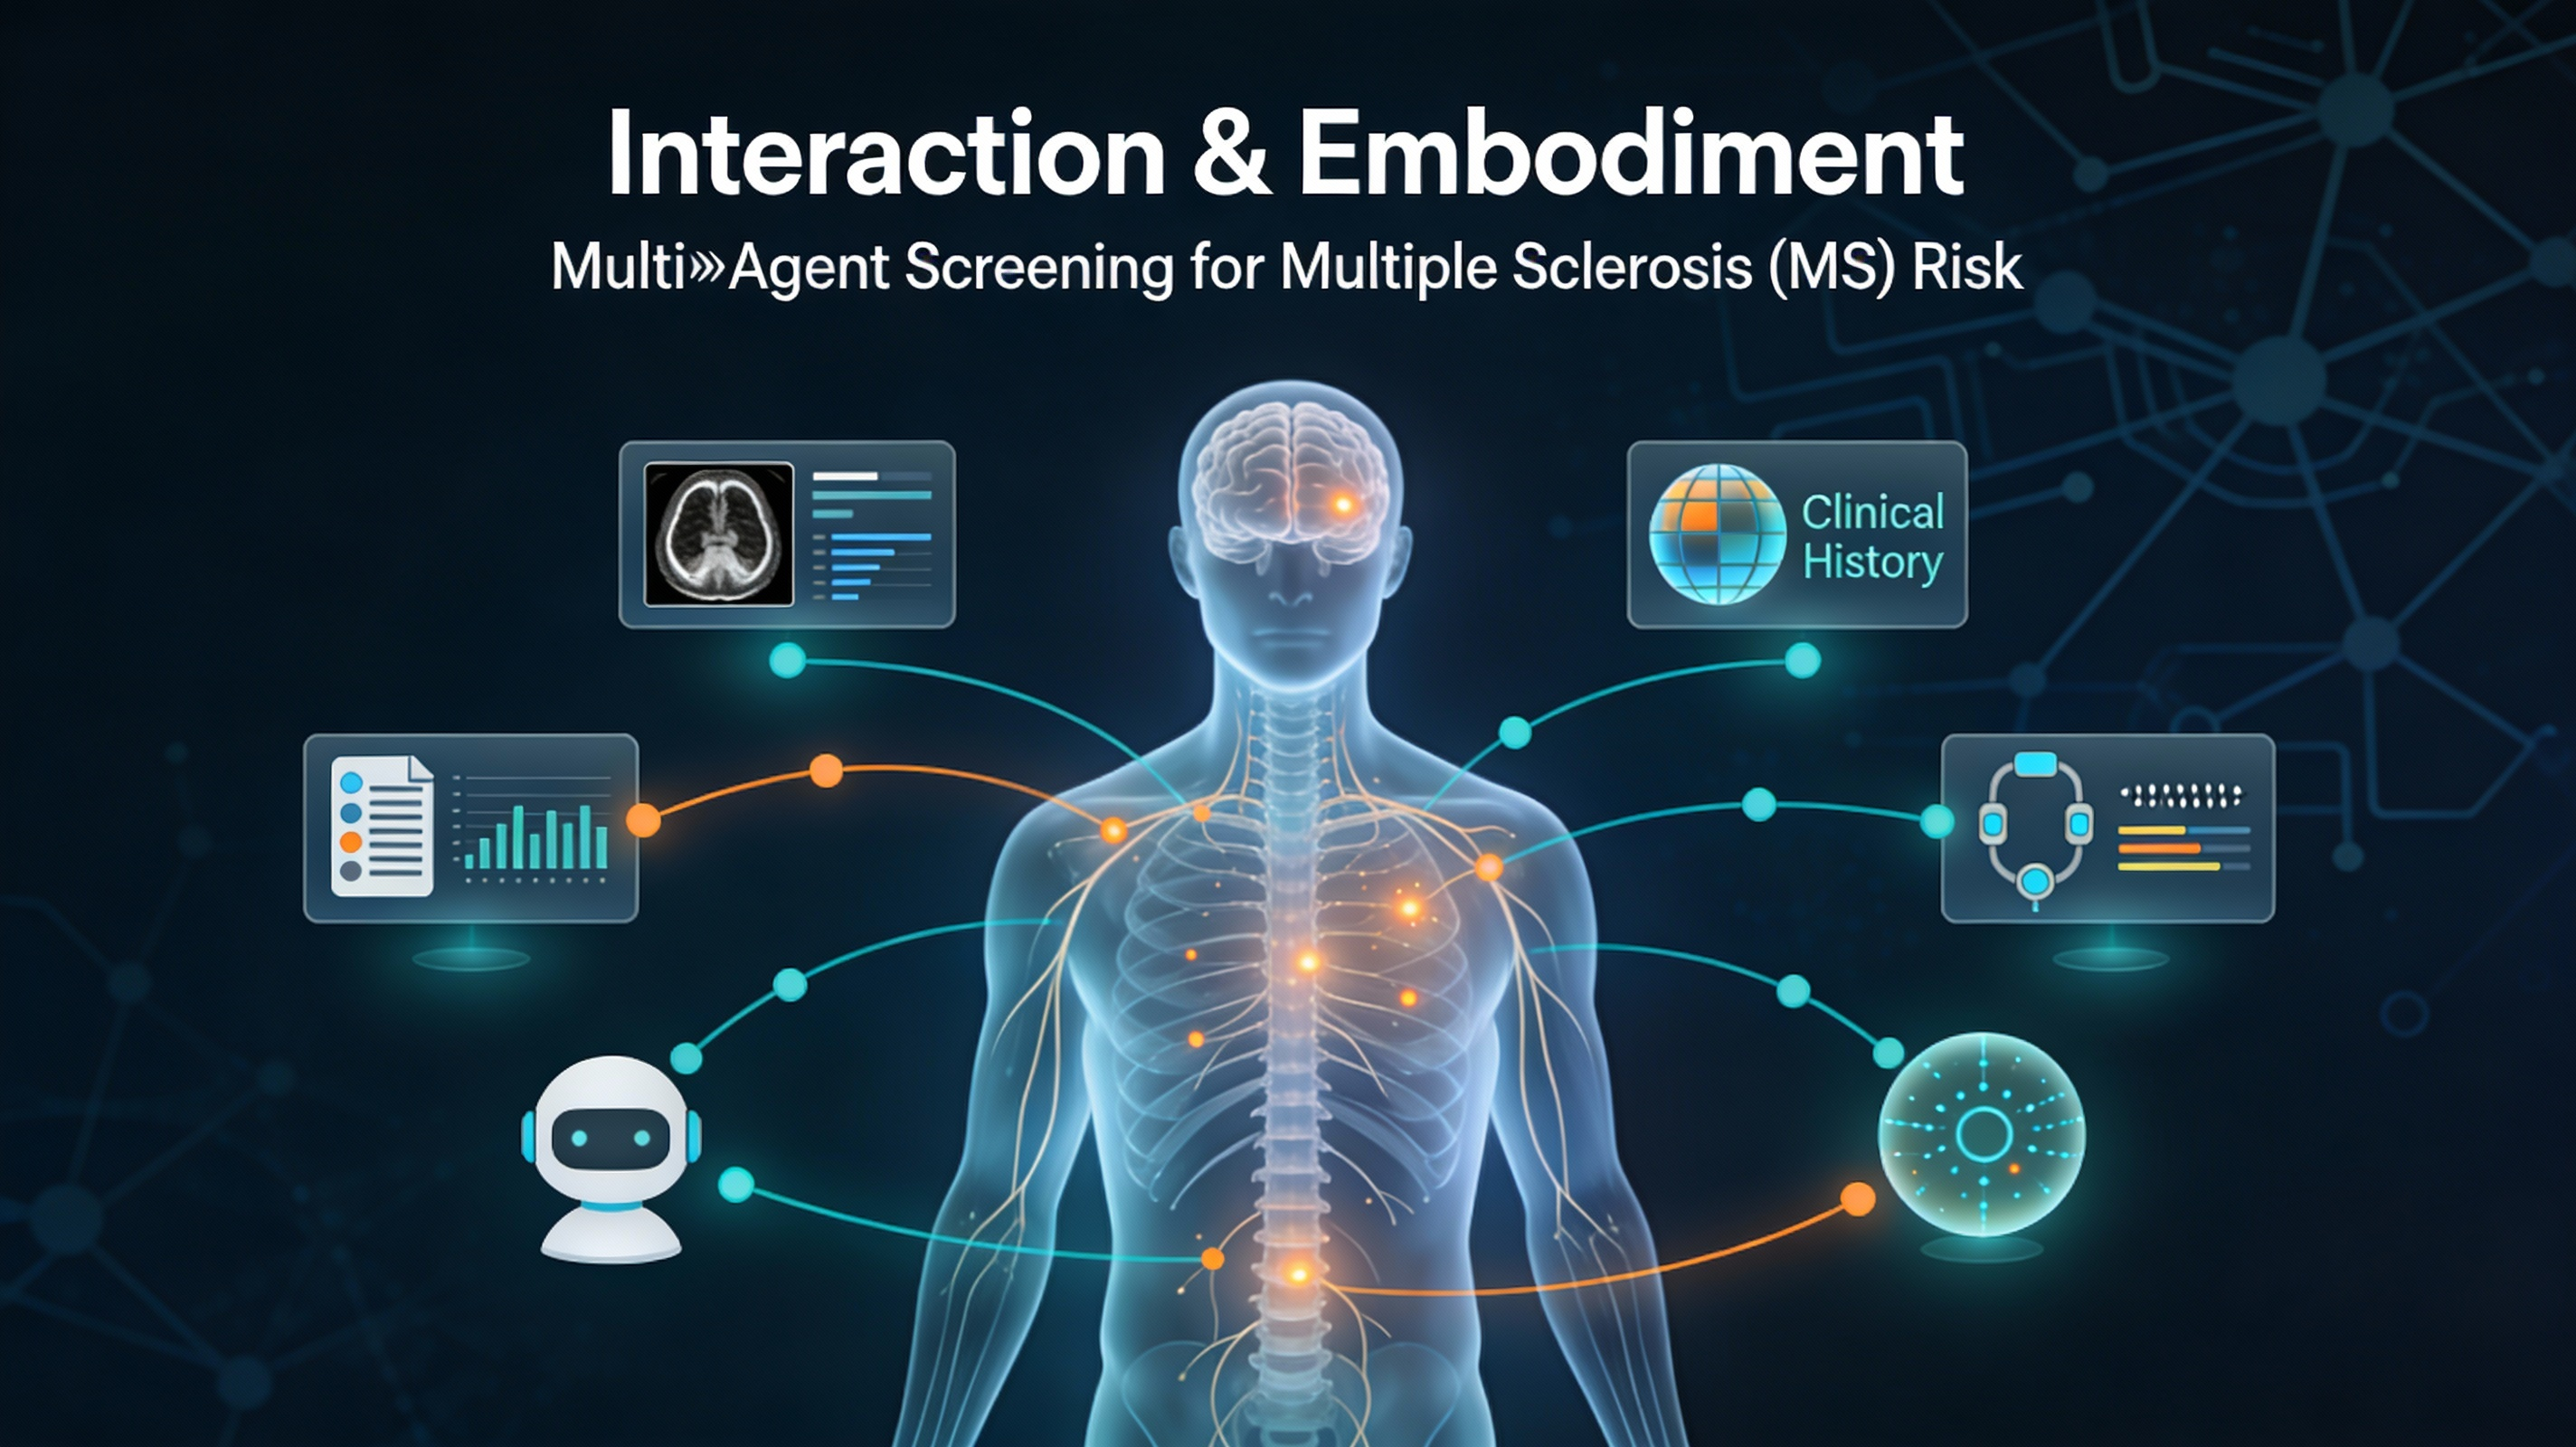

# Agentic AI Lab  
## Interaction & Embodiment — Multi‑Agent Screening for Multiple Sclerosis (MS) Risk

---

### What you’ll build
A **human-agent interaction (HAI)** inspired, multi-agent diagnosis support workflow that scans a **hospital system** to identify patients who *might* be at risk for **multiple sclerosis (MS)** and should receive clinician review.

You will model:

- **Observe → Plan → Act → Reflect** loop (systems lens)
- The **communication gap** between humans and agents (ambiguity vs precision)
- **Adjustable autonomy** (recommendation-only → semi-autonomous actions)
- **Transparency and calibration** (building appropriate trust)
- Lightweight **dashboard elements** (system performance + Responsible AI indicators)

> This notebook is designed for independent learners: exposition + checkpoints, runnable code, and clear outputs.

---

### Important note (simulation vs reality)
This notebook uses a **SIMULATED** dataset and workflow.  
Optional **ONLINE API** calls are provided as templates (opt‑in) and are clearly labeled.

Nothing here is medical advice. In real deployments, all clinical decision support must be validated, governed, and supervised by qualified clinicians.

## 0. Scenario: Hospital‑Wide MS Risk Screening

A large health system wants to reduce missed or delayed MS diagnoses by identifying patients with patterns suggestive of MS, such as:

- optic neuritis / vision changes
- paresthesias, numbness, weakness
- gait instability, vertigo, fatigue
- MRI reports with demyelinating lesions (when available)

The goal is **not** to diagnose MS automatically.  
The goal is to **flag patients for review** by a neurology team.

### Multi-agent roles
| Agent | Role |
|---|---|
| **Retrieval Agent** | Pull candidate patients from EHR-like records |
| **Phenotyping Agent** | Score MS risk from structured data (symptoms, history) |
| **Notes/Imaging Agent** | Summarize unstructured notes (optional LLM) |
| **Safety & Governance Agent** | Apply policy checks (PHI handling, escalation rules) |
| **Coordinator** | Combines evidence, chooses autonomy level, produces an action |

### 🔎 Checkpoint 0
Why is *screening for risk* a fundamentally different task than *diagnosis*?

## 1. Interaction & Embodiment Lens (from the lecture)

We treat the “environment” as a **socio-technical system**:
- clinicians, workflows, time constraints
- EHR data quality and missingness
- governance constraints
- consequences of false positives/negatives

### Observe → Plan → Act → Reflect
- **Observe:** collect evidence (structured + unstructured)
- **Plan:** decide what to do next (ask for missing info? escalate?)
- **Act:** create a recommendation or an order (depending on autonomy)
- **Reflect:** track outcomes and recalibrate

### The Communication Gap
Humans communicate with ambiguity and context. Agents require precision.
Good systems bridge this with:
- clarifying questions
- explicit uncertainty
- crisp outputs
- transparency about why a patient was flagged

### Adjustable Autonomy
Different tasks and contexts demand different initiative levels:
- recommend-only for high-risk actions
- partial automation for routine, low-risk actions
- explicit approval gates and escalation thresholds

### 🔎 Checkpoint 1
What is one workflow constraint (time, staffing, liability, etc.) that should shape how this agent behaves?

## 2. Evidence Signals and Precursors for MS Risk Screening

This lab uses **simulated** features that mimic signals commonly present *before* or *around* an MS diagnosis.  
These signals are **not diagnostic**; they are used to prioritize **clinical review**, not to make decisions autonomously.

### Examples of precursor signals (illustrative)
- **Neuro-ophthalmic events** such as optic neuritis (often documented as diagnosis codes or structured problem list entries)
- **Sensory and motor symptoms** (paresthesias, weakness, gait instability) that may appear across visits
- **MRI descriptors** that can suggest demyelination (when imaging is available)
- **Standardized assessment pathways** and structured capture (e.g., smart-form fields)

### Why structured pathways matter
Learning health systems like **MS PATHS (Multiple Sclerosis Partners Advancing Technology and Health Solutions)** emphasize standardized data collection during routine care, which can make monitoring, auditing, and subgroup analysis more reliable (Mowry et al., 2020).

### Neuroperformance testing context
Tools such as the **Multiple Sclerosis Performance Test (MSPT)** demonstrate how digital measurement batteries can standardize disability assessment (walking, manual dexterity, cognition, and more), improving consistency over time and across sites (Rudick et al., 2014).

### Vitamin D as a contextual covariate
Serum **25-hydroxyvitamin D** has been associated with MRI disease activity in some MS cohorts. In a screening pipeline, vitamin D would typically be a *context covariate*, not a trigger (Fitzgerald et al., 2015).

### 🔎 Checkpoint — Signals vs Decisions
Pick one signal above (e.g., MRI lesions or vitamin D).  
Explain why it should **influence review priority** but should **not** be treated as a standalone diagnostic criterion.

In [1]:
# ==================================
# 2. Imports & Global Configuration
# ==================================

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

random.seed(42)
np.random.seed(42)

N_PATIENTS = 2500

# Adjustable autonomy levels for the coordinator
AUTONOMY_LEVELS = ["RECOMMEND_ONLY", "DRAFT_ORDER", "AUTO_ORDER_WITH_GUARDRAILS"]

# Thresholds for escalation / autonomy (baseline)
POLICY = {
    "risk_review_threshold": 0.65,     # above => recommend neurology review
    "draft_order_threshold": 0.80,     # above => allow drafting an MRI order
    "auto_order_threshold": 0.90,      # above => allow auto-order (with guardrails)
    "max_auto_actions_per_day": 20,    # rate-limiting (simulated)
}

print("Patients:", N_PATIENTS)
print("Policy thresholds:", POLICY)

Patients: 2500
Policy thresholds: {'risk_review_threshold': 0.65, 'draft_order_threshold': 0.8, 'auto_order_threshold': 0.9, 'max_auto_actions_per_day': 20}


### 🔎 Checkpoint 2 — Governance
Who should set thresholds like these (data science, clinicians, compliance, leadership)?  
What evidence should be required to change them?

## 2. Practical “Precursors” and Data Sources for MS Risk Screening (Conceptual)

In real hospital systems, the signals that help identify patients at potential risk for MS are often distributed across **multiple data modalities**.

### 2.1 Structured “Smart Form” style fields (EHR workflow tooling)
Many EHRs support condition-specific structured documentation widgets (sometimes called *smart forms* or similar). These can improve:
- consistent symptom capture
- data completeness
- decision support hooks (e.g., “if optic neuritis + paresthesia → consider neurology review”)

A classic description of “Smart Form” style clinical workflow + data capture emphasizes organizing review, documentation, and integrated decision support in one interface. (Schnipper et al., 2008).

### 2.2 Learning health system signals: MS PATHS
**Multiple Sclerosis Partners Advancing Technology and Health Solutions (MS PATHS)** is a “learning health system” example that standardizes routine-care MS assessments and uses tools like the **Multiple Sclerosis Performance Test (MSPT)** to collect structured history, patient-reported outcomes, and quantitative neuroperformance measures, alongside standardized MRI protocols.

Practical implication for screening:
- if your hospital already collects standardized neuroperformance or patient-reported outcomes, those fields can become **high-value screening features** (with appropriate governance).

### 2.3 Vitamin D as a clinically relevant covariate (example)
Low 25-hydroxyvitamin D has been associated with MS risk and (in some contexts) MS activity; for example, a large prospective analysis in relapsing-remitting MS treated with interferon beta-1b found higher vitamin D levels associated with fewer new active MRI lesions.

In a screening workflow, vitamin D status might be used as:
- a **risk context variable** (not a diagnostic marker)
- an **equity lens** variable (access to testing/supplementation can differ by population)

### 2.4 Equity & heterogeneity reminder
Patient subgroups can differ in disease course and outcomes; MS PATHS has enabled analyses comparing groups and considering socioeconomic status, including comparisons of Black and White Americans with MS.

In a risk screening system, this motivates **routine subgroup monitoring** so the tool does not unintentionally amplify disparities.

### 🔎 Checkpoint 2A
Pick *one* signal above (smart form fields, standardized performance testing, vitamin D) and answer:
- How could it help screening?
- What could go wrong if we overweight it?

## 3. Simulated EHR Dataset (SIMULATION)

We create a synthetic dataset with:
- demographics
- symptom indicators
- prior diagnoses that mimic “look‑alikes”
- note snippets that can contain MS-like terms
- a hidden ground-truth label: “at risk for MS (needs review)”

In real life, labels are noisy and delayed. Here we use labels only to measure behavior.

> This section is simulation. Later we provide **optional online API hooks** for note summarization and explanation generation.

In [2]:
# =========================
# 3.1 Synthetic data builder
# =========================

SYMPTOMS = [
    "optic_neuritis", "paresthesia", "weakness", "gait_instability", "vertigo",
    "fatigue", "bladder_issues", "cognitive_fog"
]

LOOKALIKE_DIAG = ["migraine", "b12_deficiency", "anxiety", "fibromyalgia", "stroke_TIA", "none"]

NOTE_PHRASES_MS = [
    "demyelinating", "periventricular lesions", "oligoclonal bands", "optic neuritis",
    "relapsing symptoms", "neurology referral", "MRI brain w/wo contrast"
]
NOTE_PHRASES_NONMS = [
    "tension headache", "vitamin deficiency", "stress-related", "poor sleep",
    "peripheral neuropathy", "viral illness", "benign positional vertigo"
]

def sigmoid(x):
    return 1/(1+np.exp(-x))

def make_patients(n=N_PATIENTS):
    rows = []
    for i in range(n):
        age = int(np.clip(np.random.normal(42, 14), 18, 85))
        sex = np.random.choice(["F","M"], p=[0.62, 0.38])
        visits_last_year = int(np.clip(np.random.poisson(3), 0, 15))
        lookalike = np.random.choice(LOOKALIKE_DIAG, p=[0.18,0.10,0.12,0.08,0.05,0.47])

        # symptom probabilities (roughly plausible, not clinical)
        symptom_base = 0.08 + 0.03*(sex=="F") + 0.01*(age<55)
        symptoms = {s: int(np.random.rand() < symptom_base) for s in SYMPTOMS}

        # a few correlated symptom patterns
        if np.random.rand() < 0.05:
            symptoms["optic_neuritis"] = 1
            symptoms["paresthesia"] = int(np.random.rand() < 0.65)
        if np.random.rand() < 0.06:
            symptoms["gait_instability"] = 1
            symptoms["weakness"] = int(np.random.rand() < 0.5)

        # structured "evidence" score that generates ground truth
        # (this is our simulated world; in reality you'd learn this from data)
        struct_signal = (
            1.6*symptoms["optic_neuritis"]
            + 1.1*symptoms["paresthesia"]
            + 1.0*symptoms["weakness"]
            + 0.8*symptoms["gait_instability"]
            + 0.7*symptoms["vertigo"]
            + 0.6*symptoms["fatigue"]
            + 0.4*symptoms["bladder_issues"]
            + 0.3*symptoms["cognitive_fog"]
        )

        # look-alike diagnoses reduce the chance it's MS-like (in this sim)
        lookalike_pen = {
            "migraine": 0.6,
            "b12_deficiency": 0.7,
            "anxiety": 0.4,
            "fibromyalgia": 0.5,
            "stroke_TIA": 0.8,
            "none": 0.0
        }[lookalike]

        # note generation: sometimes contains MS phrases if signal is high
        note_ms_prob = sigmoid(struct_signal - lookalike_pen - 1.2)
        note_has_ms_terms = int(np.random.rand() < note_ms_prob)

        # build a short note
        note_terms = []
        if note_has_ms_terms:
            note_terms += random.sample(NOTE_PHRASES_MS, k=random.randint(1,3))
        else:
            note_terms += random.sample(NOTE_PHRASES_NONMS, k=random.randint(1,3))
        note = " ; ".join(note_terms)

        # MRI report availability (sim)
        has_mri = int(np.random.rand() < (0.20 + 0.10*symptoms["optic_neuritis"] + 0.05*visits_last_year/10))
        mri_lesions = int(has_mri and (np.random.rand() < sigmoid(struct_signal - 1.0)))

        # ground truth: “at-risk for MS (needs review)”
        risk_latent = sigmoid(struct_signal + 0.9*note_has_ms_terms + 0.8*mri_lesions - lookalike_pen - 1.6)
        at_risk = int(np.random.rand() < risk_latent)

        rows.append({
            "patient_id": f"P{i:05d}",
            "age": age,
            "sex": sex,
            "visits_last_year": visits_last_year,
            "lookalike_dx": lookalike,
            "note": note,
            "has_mri": has_mri,
            "mri_lesions": mri_lesions,
            "note_has_ms_terms": note_has_ms_terms,
            "true_at_risk": at_risk,
            **symptoms
        })
    return pd.DataFrame(rows)

patients = make_patients()
patients.head()

,patient_id,age,sex,visits_last_year,lookalike_dx,note,has_mri,mri_lesions,note_has_ms_terms,true_at_risk,optic_neuritis,paresthesia,weakness,gait_instability,vertigo,fatigue,bladder_issues,cognitive_fog
0,P00000,48,M,2,migraine,tension headache ; benign positional vertigo ;...,0,0,0,0,0,0,0,1,0,0,0,0
1,P00001,40,F,1,anxiety,vitamin deficiency,0,0,0,0,0,0,0,0,0,1,0,0
2,P00002,46,F,2,none,viral illness,0,0,0,1,0,0,0,0,0,0,0,0
3,P00003,33,F,0,anxiety,viral illness,1,1,0,0,0,0,0,0,0,0,0,0
4,P00004,56,M,1,migraine,relapsing symptoms ; demyelinating ; MRI brain...,0,0,1,0,0,0,0,1,0,0,0,0


In [3]:
# Pretty descriptive stats
desc = patients[["age","visits_last_year","has_mri","mri_lesions","true_at_risk"]].describe().T
desc.style.format("{:.2f}").set_caption("Synthetic dataset descriptive statistics")

,count,mean,std,min,25%,50%,75%,max
age,2500.00,42.01,13.45,18.00,32.00,42.00,51.00,85.00
visits_last_year,2500.00,2.98,1.75,0.00,2.00,3.00,4.00,12.00
has_mri,2500.00,0.22,0.42,0.00,0.00,0.00,0.00,1.00
mri_lesions,2500.00,0.11,0.31,0.00,0.00,0.00,0.00,1.00
true_at_risk,2500.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00


### 🔎 Checkpoint 3 — Sim-to-Real
This dataset is synthetic and clean compared to real EHRs.

Name **two real-world issues** (missingness, coding variability, note artifacts, etc.) that would break naïve approaches.

## 4. Multi-Agent System Design (Explicitly Modeled)

We will implement several agents, each with a narrow responsibility.

Key HAI principle:
> Systems should be *legible*: you can tell what each component did and why.

We’ll log each agent’s outputs to support transparency and debugging.

In [4]:
# =========================
# 4.1 Shared utilities
# =========================

@dataclass
class AgentOutput:
    agent: str
    patient_id: str
    payload: Dict[str, Any]

def pretty_dict(d: Dict[str, Any], max_keys=20):
    items = list(d.items())[:max_keys]
    lines = [f"- **{k}**: {v}" for k,v in items]
    return "\n".join(lines)

def contains_any(text: str, terms: List[str]) -> int:
    t = text.lower()
    return int(any(term.lower() in t for term in terms))

In [5]:
# =========================
# 4.2 Agents
# =========================

class RetrievalAgent:
    """Retrieve candidates from hospital-wide data (broad recall)."""
    name = "retrieval"

    def run(self, df: pd.DataFrame) -> List[str]:
        # Broad filter to avoid scanning every patient in real systems (simulated here).
        # Candidate rule: any neurological symptom OR MRI lesions OR MS-ish note terms OR high utilization.
        candidates = df[
            (df["mri_lesions"] == 1) |
            (df["note_has_ms_terms"] == 1) |
            (df[SYMPTOMS].sum(axis=1) >= 2) |
            (df["visits_last_year"] >= 6)
        ]["patient_id"].tolist()
        return candidates

class PhenotypingAgent:
    """Score MS risk from structured features."""
    name = "phenotyping"

    def score(self, row: pd.Series) -> Tuple[float, Dict[str, float]]:
        # Transparent linear scoring (interpretable baseline)
        weights = {
            "optic_neuritis": 0.22,
            "paresthesia": 0.14,
            "weakness": 0.13,
            "gait_instability": 0.10,
            "vertigo": 0.08,
            "fatigue": 0.06,
            "bladder_issues": 0.05,
            "cognitive_fog": 0.04,
            "mri_lesions": 0.18,
            "note_has_ms_terms": 0.12,
        }
        contrib = {k: weights[k]*float(row[k]) for k in weights}
        raw = sum(contrib.values())
        # penalty for look-alike diagnoses (simulated)
        penalty = {
            "migraine": 0.08,
            "b12_deficiency": 0.10,
            "anxiety": 0.05,
            "fibromyalgia": 0.07,
            "stroke_TIA": 0.12,
            "none": 0.00
        }[row["lookalike_dx"]]
        raw = max(0.0, raw - penalty)
        # clamp to [0,1]
        risk = float(np.clip(raw, 0.0, 1.0))
        contrib["lookalike_penalty"] = -penalty
        return risk, contrib

class NotesImagingAgent:
    """Extract evidence from unstructured notes (local heuristic + optional LLM hook)."""
    name = "notes_imaging"

    def run_local(self, row: pd.Series) -> Dict[str, Any]:
        note = row["note"]
        ms_terms = contains_any(note, NOTE_PHRASES_MS)
        nonms_terms = contains_any(note, NOTE_PHRASES_NONMS)
        return {
            "note_ms_terms_flag": ms_terms,
            "note_nonms_terms_flag": nonms_terms,
            "note_excerpt": note[:200]
        }

class SafetyGovernanceAgent:
    """Apply policy checks: data handling, uncertainty, and autonomy constraints."""
    name = "safety_governance"

    def run(self, patient_row: pd.Series, risk: float) -> Dict[str, Any]:
        flags = []
        # PHI/Protected data checks would go here; we simulate a safe handling rule:
        if len(patient_row.get("note","")) > 0 and "name:" in patient_row.get("note","").lower():
            flags.append("POTENTIAL_PHI_IN_NOTE")

        # Uncertainty / missingness heuristics
        if patient_row["has_mri"] == 0 and patient_row[SYMPTOMS].sum() <= 1:
            flags.append("LOW_EVIDENCE_CASE")

        # Guardrail: do not allow automation for minors (example)
        if patient_row["age"] < 18:
            flags.append("MINOR_PATIENT_REQUIRES_MANUAL_REVIEW")

        # Guardrail: if risk is very high but based on weak evidence, force review
        if risk >= 0.90 and "LOW_EVIDENCE_CASE" in flags:
            flags.append("HIGH_RISK_LOW_EVIDENCE")

        return {"flags": flags, "flag_count": len(flags)}

In [6]:
# =========================
# 4.3 Coordinator (Adjustable Autonomy + Transparency)
# =========================

class Coordinator:
    name = "coordinator"
    def __init__(self, policy: Dict[str, Any]):
        self.policy = policy
        self.auto_actions_used = 0  # per-day rate-limit simulation

    def decide(self, risk: float, safety_payload: Dict[str, Any]) -> Dict[str, Any]:
        flags = safety_payload["flags"]
        # default decision
        action = "NO_ACTION"
        autonomy = "RECOMMEND_ONLY"
        rationale = []

        if risk >= self.policy["risk_review_threshold"]:
            action = "RECOMMEND_NEURO_REVIEW"
            rationale.append("risk_above_review_threshold")

        # Adjustable autonomy gates
        if risk >= self.policy["draft_order_threshold"] and len(flags) == 0:
            autonomy = "DRAFT_ORDER"
            action = "DRAFT_MRI_ORDER"
            rationale.append("risk_above_draft_threshold_and_no_flags")

        if risk >= self.policy["auto_order_threshold"] and len(flags) == 0:
            if self.auto_actions_used < self.policy["max_auto_actions_per_day"]:
                autonomy = "AUTO_ORDER_WITH_GUARDRAILS"
                action = "AUTO_ORDER_MRI_AND_NOTIFY_NEURO"
                self.auto_actions_used += 1
                rationale.append("risk_above_auto_threshold_and_within_rate_limit")
            else:
                autonomy = "DRAFT_ORDER"
                action = "DRAFT_MRI_ORDER"
                rationale.append("auto_rate_limited_fallback_to_draft")

        # If any governance flags exist, force recommend-only
        if len(flags) > 0 and action != "NO_ACTION":
            autonomy = "RECOMMEND_ONLY"
            rationale.append("governance_flags_force_human_review")

        return {
            "action": action,
            "autonomy_level": autonomy,
            "rationale": rationale
        }

### ✅ Multi-Agent Verification (Explicit)

This workflow is **multi-agent** because it includes multiple specialized agents that each produce an output, plus a **Coordinator** that makes the final decision.

We can verify this in code by listing the agent objects and their responsibilities.

In [7]:
# =========================
# Multi-agent objects guard
# =========================
# Ensure agent instances exist (safe for re-runs).

if "retrieval" not in globals():
    retrieval = RetrievalAgent()
if "phenotype" not in globals():
    phenotype = PhenotypingAgent()
if "notes_agent" not in globals():
    notes_agent = NotesImagingAgent()
if "safety" not in globals():
    safety = SafetyGovernanceAgent()
if "coord" not in globals():
    coord = Coordinator(policy=POLICY)

In [8]:
# Verify that we have multiple agents + a coordinator
agent_objects = {
    "RetrievalAgent": retrieval,
    "PhenotypingAgent": phenotype,
    "NotesImagingAgent": notes_agent,
    "SafetyGovernanceAgent": safety,
    "Coordinator": coord,
}
pd.DataFrame(
    [{"component": k, "type": type(v).__name__} for k,v in agent_objects.items()]
).style.hide(axis="index").set_caption("Multi-agent components present in this notebook")

component,type
RetrievalAgent,RetrievalAgent
PhenotypingAgent,PhenotypingAgent
NotesImagingAgent,NotesImagingAgent
SafetyGovernanceAgent,SafetyGovernanceAgent
Coordinator,Coordinator


### 🔎 Checkpoint 4 — Shared Mental Models
If a clinician receives a flag, what *minimum explanation* should be shown so they can calibrate trust appropriately?

## 5. Run the Multi-Agent Workflow (SIMULATION)

We now execute the workflow:
1. Retrieval agent selects candidates (broad recall)
2. For each candidate:
   - phenotyping risk score + contributions
   - notes evidence summary
   - safety/governance flags
   - coordinator decision + autonomy

We also log agent outputs to support transparency.

In [9]:
# =========================
# 5.1 Execute workflow
# =========================

retrieval = RetrievalAgent()
phenotype = PhenotypingAgent()
notes_agent = NotesImagingAgent()
safety = SafetyGovernanceAgent()
coord = Coordinator(policy=POLICY)

candidate_ids = retrieval.run(patients)
print("Candidates retrieved:", len(candidate_ids), "of", len(patients))

logs: List[AgentOutput] = []
results = []

df_index = patients.set_index("patient_id")

for pid in candidate_ids:
    row = df_index.loc[pid]

    risk, contrib = phenotype.score(row)
    notes_payload = notes_agent.run_local(row)
    safety_payload = safety.run(row, risk)
    decision = coord.decide(risk, safety_payload)

    logs.append(AgentOutput(agent="phenotyping", patient_id=pid, payload={"risk": risk, "contrib": contrib}))
    logs.append(AgentOutput(agent="notes_imaging", patient_id=pid, payload=notes_payload))
    logs.append(AgentOutput(agent="safety_governance", patient_id=pid, payload=safety_payload))
    logs.append(AgentOutput(agent="coordinator", patient_id=pid, payload=decision))

    results.append({
        "patient_id": pid,
        "risk_score": risk,
        "action": decision["action"],
        "autonomy_level": decision["autonomy_level"],
        "flags": ",".join(safety_payload["flags"]),
        "flag_count": safety_payload["flag_count"],
        "true_at_risk": int(row["true_at_risk"]),
        "coinsidence_ms_terms_note": int(notes_payload["note_ms_terms_flag"]),
        "mri_lesions": int(row["mri_lesions"]),
        "symptom_count": int(row[SYMPTOMS].sum()),
        "lookalike_dx": row["lookalike_dx"],
    })

out = pd.DataFrame(results)
out.head()

Candidates retrieved: 1382 of 2500


,patient_id,risk_score,action,autonomy_level,flags,flag_count,true_at_risk,coinsidence_ms_terms_note,mri_lesions,symptom_count,lookalike_dx
0,P00003,0.13,NO_ACTION,RECOMMEND_ONLY,,0,0,0,1,0,anxiety
1,P00004,0.14,NO_ACTION,RECOMMEND_ONLY,LOW_EVIDENCE_CASE,1,0,1,0,1,migraine
2,P00005,0.26,NO_ACTION,RECOMMEND_ONLY,,0,0,1,0,1,migraine
3,P00007,0.17,NO_ACTION,RECOMMEND_ONLY,,0,0,0,0,2,anxiety
4,P00008,0.19,NO_ACTION,RECOMMEND_ONLY,,0,0,0,0,2,none


In [10]:
# Pretty top-risk table
top = out.sort_values("risk_score", ascending=False).head(12).merge(
    patients[["patient_id","age","sex","visits_last_year","note"]], on="patient_id", how="left"
)

top_display = top[["patient_id","risk_score","action","autonomy_level","flag_count","flags","true_at_risk","age","sex","visits_last_year","note"]]
top_display.style.format({"risk_score":"{:.2f}"}).set_caption("Top flagged patients (simulation)")

,patient_id,risk_score,action,autonomy_level,flag_count,flags,true_at_risk,age,sex,visits_last_year,note
0,P02126,0.93,AUTO_ORDER_MRI_AND_NOTIFY_NEURO,AUTO_ORDER_WITH_GUARDRAILS,0,,1,41,F,5,MRI brain w/wo contrast ; oligoclonal bands ; periventricular lesions
1,P00494,0.84,DRAFT_MRI_ORDER,DRAFT_ORDER,0,,1,43,F,1,neurology referral ; periventricular lesions ; optic neuritis
2,P01080,0.84,DRAFT_MRI_ORDER,DRAFT_ORDER,0,,1,47,M,4,MRI brain w/wo contrast ; optic neuritis
3,P00879,0.80,DRAFT_MRI_ORDER,DRAFT_ORDER,0,,1,51,F,3,optic neuritis ; oligoclonal bands ; relapsing symptoms
4,P01295,0.76,RECOMMEND_NEURO_REVIEW,RECOMMEND_ONLY,0,,1,56,M,6,neurology referral ; periventricular lesions ; optic neuritis
5,P01369,0.76,RECOMMEND_NEURO_REVIEW,RECOMMEND_ONLY,0,,1,25,F,3,periventricular lesions ; oligoclonal bands ; MRI brain w/wo contrast
6,P02480,0.75,RECOMMEND_NEURO_REVIEW,RECOMMEND_ONLY,0,,1,49,M,8,relapsing symptoms ; periventricular lesions ; optic neuritis
7,P01868,0.75,RECOMMEND_NEURO_REVIEW,RECOMMEND_ONLY,0,,1,33,F,4,periventricular lesions ; MRI brain w/wo contrast ; relapsing symptoms
8,P02245,0.72,RECOMMEND_NEURO_REVIEW,RECOMMEND_ONLY,0,,1,75,M,1,neurology referral ; demyelinating
9,P01166,0.72,RECOMMEND_NEURO_REVIEW,RECOMMEND_ONLY,0,,1,23,M,2,neurology referral


### 🔎 Checkpoint 5 — Communication Gap
Look at the table. Imagine you are a clinician.

What parts are still ambiguous?  
What would you ask the system to clarify before acting?

In [11]:
# =========================
# Safety guard: ensure key variables exist
# =========================
# Recompute candidate_ids and out if a learner ran cells out of order.

if "candidate_ids" not in globals() or "out" not in globals():
    print("Recomputing candidate_ids and out (safe rebuild)...")

    retrieval = RetrievalAgent()
    phenotype = PhenotypingAgent()
    notes_agent = NotesImagingAgent()
    safety = SafetyGovernanceAgent()
    coord = Coordinator(policy=POLICY)

    candidate_ids = retrieval.run(patients)

    results = []
    df_index = patients.set_index("patient_id")

    for pid in candidate_ids:
        row = df_index.loc[pid]

        risk, contrib = phenotype.score(row)
        notes_payload = notes_agent.run_local(row)
        safety_payload = safety.run(row, risk)
        decision = coord.decide(risk, safety_payload)

        results.append({
            "patient_id": pid,
            "risk_score": risk,
            "action": decision["action"],
            "autonomy_level": decision["autonomy_level"],
            "flags": ",".join(safety_payload["flags"]),
            "flag_count": safety_payload["flag_count"],
            "true_at_risk": int(row["true_at_risk"]),
            "mri_lesions": int(row["mri_lesions"]),
            "symptom_count": int(row[SYMPTOMS].sum()),
            "lookalike_dx": row["lookalike_dx"],
        })

    out = pd.DataFrame(results)

print("candidate_ids:", len(candidate_ids))
print("out rows:", len(out))

candidate_ids: 1382
out rows: 1382


## 6. Dashboard Views (System Health + Responsible AI Indicators)

Dashboards should support **decisions**, not just reporting.

We’ll compute and plot:
- overall screening performance (precision/recall style)
- workload (how many flags)
- autonomy distribution (how often actions are drafted/auto)
- safety flags rate (Responsible AI indicator)
- calibration slices (risk vs outcomes)

## 6B. Fairness Dashboard: Flags by Demographics and Patient Subtypes

A practical screening system must monitor whether **flag rates** and **automation rates** differ across groups.  
Differences can reflect:
- real differences in prevalence/severity
- differences in documentation quality
- unequal access to testing (e.g., MRI availability)
- model bias or selection bias

This is not “fairness solved”—it is **continuous monitoring**.

We will compare (on the *candidate set*):
- flag rate by **sex**
- flag rate by **age band**
- flag rate by **look-alike diagnosis subtype**
- automation rate by group (draft/auto)

### 🔎 Checkpoint — Interpreting Disparities
If you observe a higher flag rate in one subgroup, list **two plausible explanations**:
1) a clinical/epidemiologic explanation  
2) a data/workflow/system explanation

/tmp/ipython-input-2856013075.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(group_col).agg(


,sex,n,flagged_rate,avg_risk,auto_or_draft_rate,auto_rate,safety_flag_rate,true_at_risk_rate,mri_rate
0,F,869,0.024,0.242,0.003,0.001,0.341,0.542,0.282
1,M,513,0.033,0.236,0.002,0.000,0.351,0.520,0.300


,age_band,n,flagged_rate,avg_risk,auto_or_draft_rate,auto_rate,safety_flag_rate,true_at_risk_rate,mri_rate
0,<30,263,0.023,0.226,0.000,0.000,0.411,0.510,0.270
1,30-39,332,0.018,0.234,0.000,0.000,0.331,0.530,0.286
2,40-49,400,0.033,0.263,0.007,0.003,0.297,0.593,0.300
3,50-59,253,0.043,0.237,0.004,0.000,0.372,0.542,0.304
4,60-69,96,0.010,0.223,0.000,0.000,0.323,0.417,0.250
5,70+,38,0.026,0.198,0.000,0.000,0.368,0.368,0.316


,lookalike_dx,n,flagged_rate,avg_risk,auto_or_draft_rate,auto_rate,safety_flag_rate,true_at_risk_rate,mri_rate
0,anxiety,169,0.012,0.244,0.000,0.000,0.296,0.538,0.284
1,b12_deficiency,125,0.024,0.181,0.000,0.000,0.336,0.472,0.296
2,fibromyalgia,101,0.000,0.180,0.000,0.000,0.337,0.426,0.297
3,migraine,236,0.025,0.229,0.004,0.000,0.275,0.496,0.390
4,none,690,0.038,0.268,0.004,0.001,0.384,0.577,0.252
5,stroke_TIA,61,0.016,0.164,0.000,0.000,0.328,0.492,0.295


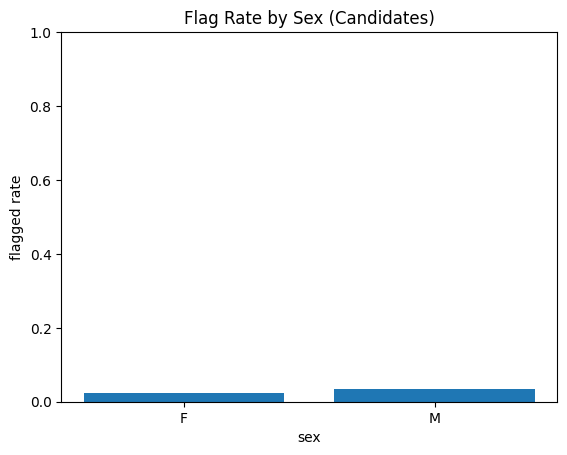

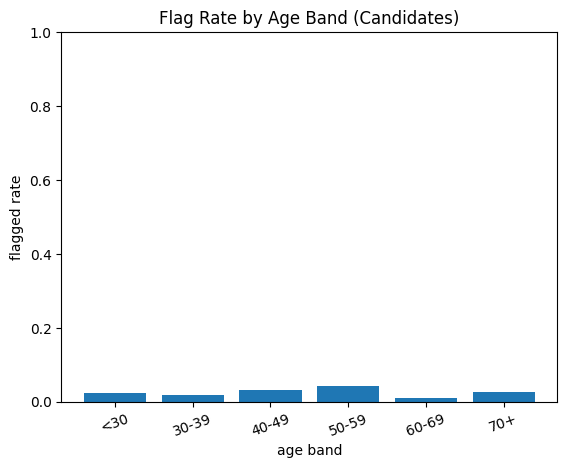

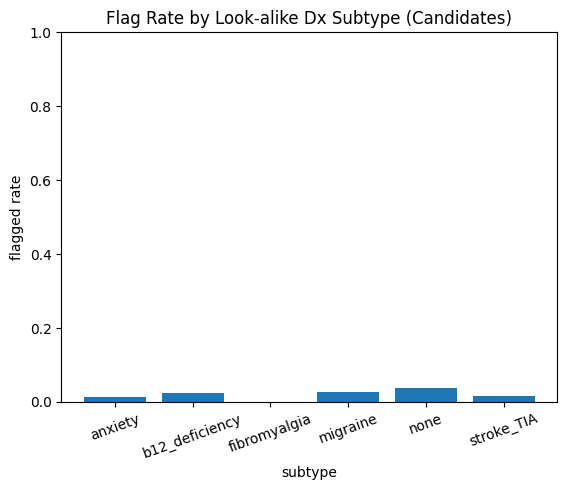

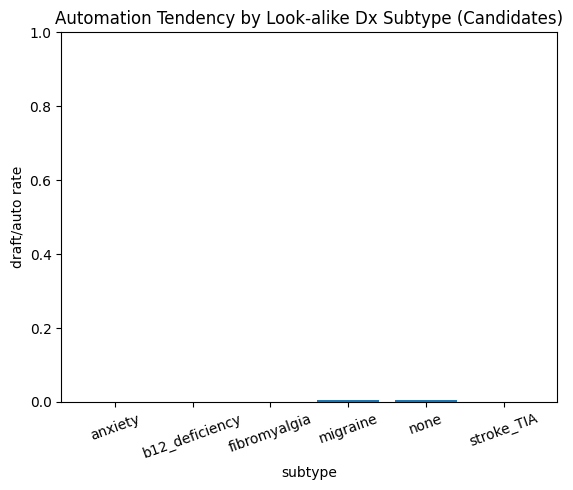

In [12]:
# =========================
# 6B.1 Fairness / subgroup dashboard
# =========================

# Join candidate outputs back to demographics
cand = out.merge(
    patients[["patient_id","age","sex","lookalike_dx","has_mri"]],
    on="patient_id", how="left"
)

# Handle possible column suffixes after merge
if 'lookalike_dx' not in cand.columns:
    if 'lookalike_dx_y' in cand.columns:
        cand['lookalike_dx'] = cand['lookalike_dx_y']
    elif 'lookalike_dx_x' in cand.columns:
        cand['lookalike_dx'] = cand['lookalike_dx_x']
if 'sex' not in cand.columns and 'sex_y' in cand.columns:
    cand['sex'] = cand['sex_y']
if 'age' not in cand.columns and 'age_y' in cand.columns:
    cand['age'] = cand['age_y']
if 'has_mri' not in cand.columns and 'has_mri_y' in cand.columns:
    cand['has_mri'] = cand['has_mri_y']

cand["flagged"] = (cand["action"] != "NO_ACTION").astype(int)
cand["auto_or_draft"] = cand["autonomy_level"].isin(["DRAFT_ORDER","AUTO_ORDER_WITH_GUARDRAILS"]).astype(int)
cand["auto"] = (cand["autonomy_level"] == "AUTO_ORDER_WITH_GUARDRAILS").astype(int)

# Age bands
bins = [0, 29, 39, 49, 59, 69, 120]
labels = ["<30","30-39","40-49","50-59","60-69","70+"]
cand["age_band"] = pd.cut(cand["age"], bins=bins, labels=labels, right=True)

def subgroup_table(df, group_col):
    g = df.groupby(group_col).agg(
        n=("patient_id","count"),
        flagged_rate=("flagged","mean"),
        avg_risk=("risk_score","mean"),
        auto_or_draft_rate=("auto_or_draft","mean"),
        auto_rate=("auto","mean"),
        safety_flag_rate=("flag_count", lambda x: (x>0).mean()),
        true_at_risk_rate=("true_at_risk","mean"),
        mri_rate=("has_mri","mean"),
    ).reset_index()
    return g

tbl_sex = subgroup_table(cand, "sex")
tbl_age = subgroup_table(cand, "age_band")
tbl_dx  = subgroup_table(cand, "lookalike_dx")

display(tbl_sex.style.format({
    "flagged_rate":"{:.3f}","avg_risk":"{:.3f}","auto_or_draft_rate":"{:.3f}",
    "auto_rate":"{:.3f}","safety_flag_rate":"{:.3f}","true_at_risk_rate":"{:.3f}","mri_rate":"{:.3f}"
}).set_caption("Fairness dashboard: outcomes by sex (candidate set)"))

display(tbl_age.style.format({
    "flagged_rate":"{:.3f}","avg_risk":"{:.3f}","auto_or_draft_rate":"{:.3f}",
    "auto_rate":"{:.3f}","safety_flag_rate":"{:.3f}","true_at_risk_rate":"{:.3f}","mri_rate":"{:.3f}"
}).set_caption("Fairness dashboard: outcomes by age band (candidate set)"))

display(tbl_dx.style.format({
    "flagged_rate":"{:.3f}","avg_risk":"{:.3f}","auto_or_draft_rate":"{:.3f}",
    "auto_rate":"{:.3f}","safety_flag_rate":"{:.3f}","true_at_risk_rate":"{:.3f}","mri_rate":"{:.3f}"
}).set_caption("Fairness dashboard: outcomes by look-alike diagnosis subtype (candidate set)"))

# Lightweight "dashboard" plots
plt.figure()
plt.bar(tbl_sex["sex"].astype(str), tbl_sex["flagged_rate"])
plt.title("Flag Rate by Sex (Candidates)")
plt.xlabel("sex")
plt.ylabel("flagged rate")
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.bar(tbl_age["age_band"].astype(str), tbl_age["flagged_rate"])
plt.title("Flag Rate by Age Band (Candidates)")
plt.xlabel("age band")
plt.ylabel("flagged rate")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.bar(tbl_dx["lookalike_dx"].astype(str), tbl_dx["flagged_rate"])
plt.title("Flag Rate by Look-alike Dx Subtype (Candidates)")
plt.xlabel("subtype")
plt.ylabel("flagged rate")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.bar(tbl_dx["lookalike_dx"].astype(str), tbl_dx["auto_or_draft_rate"])
plt.title("Automation Tendency by Look-alike Dx Subtype (Candidates)")
plt.xlabel("subtype")
plt.ylabel("draft/auto rate")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.show()

In [13]:
# =========================
# 6.1 Metrics
# =========================

def confusion_counts(df):
    # define "positive" as action != NO_ACTION
    y_true = df["true_at_risk"].astype(int).values
    y_pred = (df["action"] != "NO_ACTION").astype(int).values
    tp = int(((y_true==1) & (y_pred==1)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    return tp, fp, tn, fn

tp, fp, tn, fn = confusion_counts(out)

precision = tp / (tp+fp+1e-9)
recall = tp / (tp+fn+1e-9)

metrics = pd.DataFrame({
    "metric": ["candidates_retrieved","flagged_count","precision_on_candidates","recall_on_candidates",
               "auto_actions","draft_actions","recommend_actions","safety_flag_rate"],
    "value": [
        len(candidate_ids),
        int((out["action"] != "NO_ACTION").sum()),
        precision,
        recall,
        int((out["autonomy_level"]=="AUTO_ORDER_WITH_GUARDRAILS").sum()),
        int((out["autonomy_level"]=="DRAFT_ORDER").sum()),
        int((out["autonomy_level"]=="RECOMMEND_ONLY").sum()),
        float((out["flag_count"]>0).mean())
    ]
})

metrics.style.format({"value":"{:.3f}"}).set_caption("System health metrics (on candidate set)")

,metric,value
0,candidates_retrieved,1382.000
1,flagged_count,38.000
2,precision_on_candidates,0.947
3,recall_on_candidates,0.049
4,auto_actions,1.000
5,draft_actions,3.000
6,recommend_actions,1378.000
7,safety_flag_rate,0.344


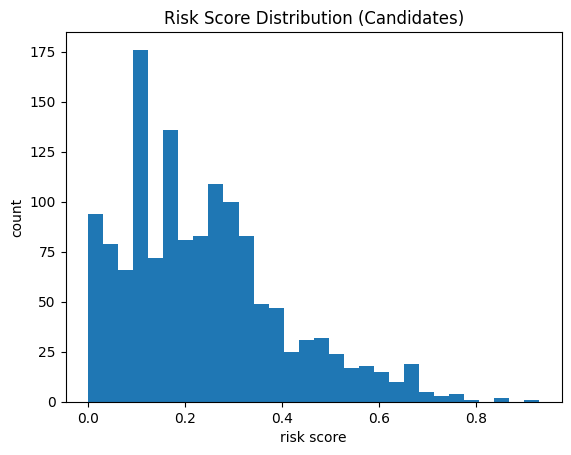

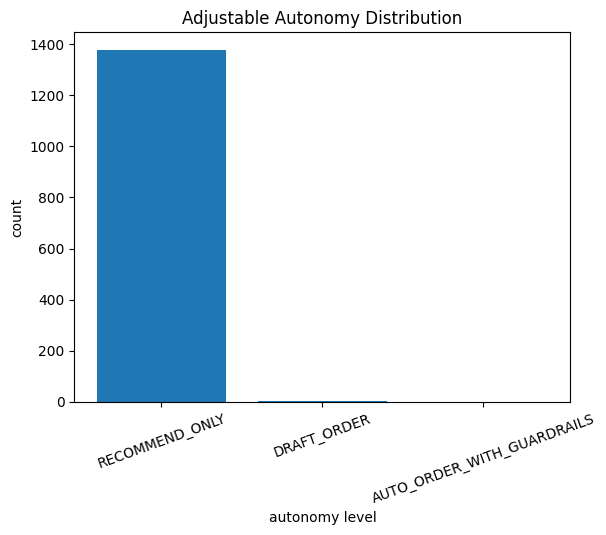

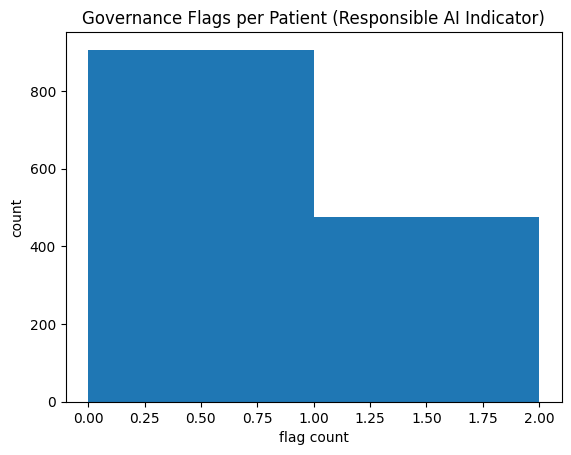

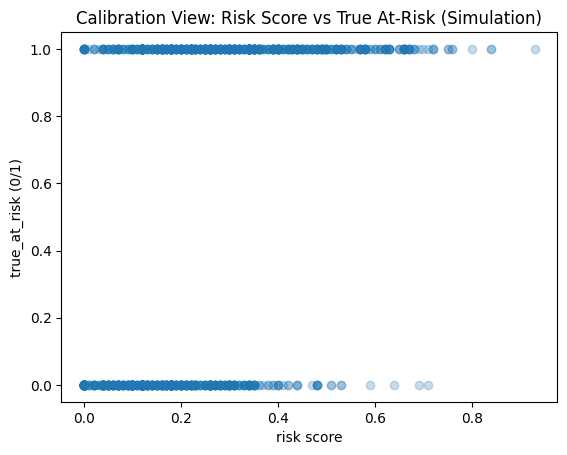

In [14]:
# =========================
# 6.2 Dashboard-like plots
# =========================

plt.figure()
plt.hist(out["risk_score"], bins=30)
plt.title("Risk Score Distribution (Candidates)")
plt.xlabel("risk score")
plt.ylabel("count")
plt.show()

plt.figure()
aut_counts = out["autonomy_level"].value_counts()
plt.bar(aut_counts.index, aut_counts.values)
plt.title("Adjustable Autonomy Distribution")
plt.xlabel("autonomy level")
plt.ylabel("count")
plt.xticks(rotation=20)
plt.show()

plt.figure()
plt.hist(out["flag_count"], bins=range(0, out["flag_count"].max()+2))
plt.title("Governance Flags per Patient (Responsible AI Indicator)")
plt.xlabel("flag count")
plt.ylabel("count")
plt.show()

plt.figure()
plt.scatter(out["risk_score"], out["true_at_risk"], alpha=0.25)
plt.title("Calibration View: Risk Score vs True At-Risk (Simulation)")
plt.xlabel("risk score")
plt.ylabel("true_at_risk (0/1)")
plt.show()

### 🔎 Checkpoint 6 — Responsible AI
If the safety flag rate increases, what could it mean?

Give two interpretations:
1) the system is getting worse  
2) the system is getting better

## 7. Transparency: Patient-Level “Why was I flagged?” Cards

A common failure mode in decision support tools is **opaque alerts**.

Here we generate a compact “patient card” that:
- lists major contributing factors
- shows governance flags
- states the coordinator’s action + autonomy

In [15]:
def build_patient_card(pid: str):
    row = df_index.loc[pid]
    # pull logged outputs
    ph = next(l.payload for l in logs if l.agent=="phenotyping" and l.patient_id==pid)
    nt = next(l.payload for l in logs if l.agent=="notes_imaging" and l.patient_id==pid)
    sg = next(l.payload for l in logs if l.agent=="safety_governance" and l.patient_id==pid)
    co = next(l.payload for l in logs if l.agent=="coordinator" and l.patient_id==pid)

    contrib = ph["contrib"]
    top_contrib = sorted(contrib.items(), key=lambda kv: abs(kv[1]), reverse=True)[:6]

    card = {
        "patient_id": pid,
        "risk_score": round(ph["risk"], 3),
        "top_factors": top_contrib,
        "note_excerpt": nt["note_excerpt"],
        "governance_flags": sg["flags"],
        "decision": co
    }
    return card

example_pid = top_display.iloc[0]["patient_id"]
card = build_patient_card(example_pid)
card

{'patient_id': 'P02126',
 'risk_score': 0.93,
 'top_factors': [('optic_neuritis', 0.22),
  ('mri_lesions', 0.18),
  ('paresthesia', 0.14),
  ('weakness', 0.13),
  ('note_has_ms_terms', 0.12),
  ('gait_instability', 0.1)],
 'note_excerpt': 'MRI brain w/wo contrast ; oligoclonal bands ; periventricular lesions',
 'governance_flags': [],
 'decision': {'action': 'AUTO_ORDER_MRI_AND_NOTIFY_NEURO',
  'autonomy_level': 'AUTO_ORDER_WITH_GUARDRAILS',
  'rationale': ['risk_above_review_threshold',
   'risk_above_draft_threshold_and_no_flags',
   'risk_above_auto_threshold_and_within_rate_limit']}}

In [16]:
# Pretty print patient card
print(f"### Patient Card: {card['patient_id']}\n")
print(f"Risk score: {card['risk_score']}")
print("\nTop contributing factors:")
for k,v in card["top_factors"]:
    print(f" - {k}: {v:+.3f}")
print("\nNote excerpt:")
print(" ", card["note_excerpt"])
print("\nGovernance flags:", card["governance_flags"])
print("\nDecision:")
print(" ", card["decision"])

### Patient Card: P02126

Risk score: 0.93

Top contributing factors:
 - optic_neuritis: +0.220
 - mri_lesions: +0.180
 - paresthesia: +0.140
 - weakness: +0.130
 - note_has_ms_terms: +0.120
 - gait_instability: +0.100

Note excerpt:
  MRI brain w/wo contrast ; oligoclonal bands ; periventricular lesions

Governance flags: []

Decision:
  {'action': 'AUTO_ORDER_MRI_AND_NOTIFY_NEURO', 'autonomy_level': 'AUTO_ORDER_WITH_GUARDRAILS', 'rationale': ['risk_above_review_threshold', 'risk_above_draft_threshold_and_no_flags', 'risk_above_auto_threshold_and_within_rate_limit']}


### 🔎 Checkpoint 7 — Calibration
Would this explanation be sufficient for clinician trust?  
If not, what would you add or remove?

## 8. Adjustable Autonomy Stress Test (What-If)

We now vary thresholds to see how:
- workload changes
- precision/recall tradeoffs shift
- auto-actions and governance enforcement behave

This is the “engineering” part of interaction design: you cannot reason about trust without measuring how policy knobs affect outcomes.

In [17]:
def run_with_policy(policy_overrides: Dict[str, Any], n_limit=None):
    pol = dict(POLICY)
    pol.update(policy_overrides)
    coord2 = Coordinator(policy=pol)
    results2 = []
    for pid in candidate_ids[: (n_limit or len(candidate_ids))]:
        row = df_index.loc[pid]
        risk, contrib = phenotype.score(row)
        safety_payload = safety.run(row, risk)
        decision = coord2.decide(risk, safety_payload)
        results2.append({
            "patient_id": pid,
            "risk_score": risk,
            "action": decision["action"],
            "autonomy_level": decision["autonomy_level"],
            "flag_count": safety_payload["flag_count"],
            "true_at_risk": int(row["true_at_risk"])
        })
    d = pd.DataFrame(results2)
    tp, fp, tn, fn = confusion_counts(d)
    return {
        "policy": pol,
        "flagged": int((d["action"]!="NO_ACTION").sum()),
        "precision": tp/(tp+fp+1e-9),
        "recall": tp/(tp+fn+1e-9),
        "auto": int((d["autonomy_level"]=="AUTO_ORDER_WITH_GUARDRAILS").sum()),
        "draft": int((d["autonomy_level"]=="DRAFT_ORDER").sum()),
        "recommend": int((d["autonomy_level"]=="RECOMMEND_ONLY").sum()),
        "flag_rate": float((d["flag_count"]>0).mean()),
        "df": d
    }

policies = [
    {"name":"baseline", "override":{}},
    {"name":"more_conservative", "override":{"risk_review_threshold":0.72, "draft_order_threshold":0.86, "auto_order_threshold":0.94}},
    {"name":"more_aggressive", "override":{"risk_review_threshold":0.55, "draft_order_threshold":0.74, "auto_order_threshold":0.88}},
    {"name":"no_auto", "override":{"auto_order_threshold":1.01}},
]

runs = []
run_dfs = {}
for p in policies:
    r = run_with_policy(p["override"])
    runs.append({"policy":p["name"], **{k:v for k,v in r.items() if k not in ["policy","df"]}})
    run_dfs[p["name"]] = r["df"]

pd.DataFrame(runs).style.format({"precision":"{:.3f}","recall":"{:.3f}","flag_rate":"{:.3f}"}).set_caption("Policy what-if outcomes (simulation)")

,policy,flagged,precision,recall,auto,draft,recommend,flag_rate
0,baseline,38,0.947,0.049,1,3,1378,0.344
1,more_conservative,11,1.000,0.015,0,1,1381,0.344
2,more_aggressive,79,0.949,0.102,1,7,1374,0.344
3,no_auto,38,0.947,0.049,0,4,1378,0.344


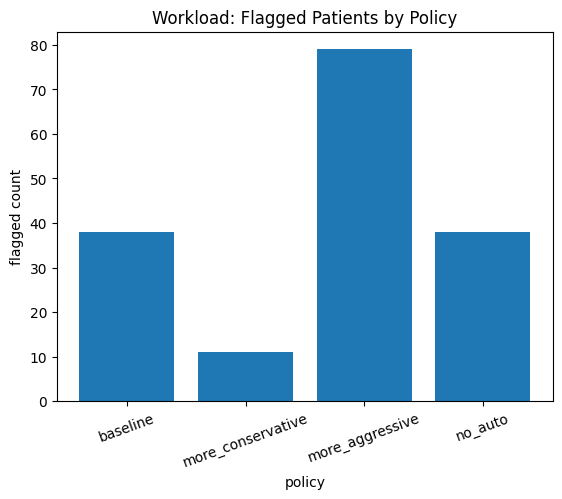

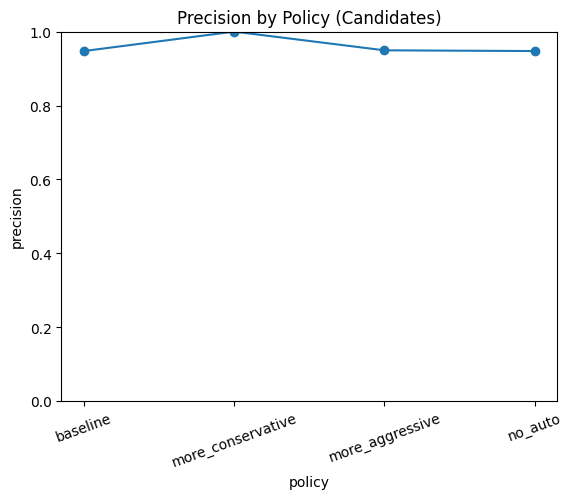

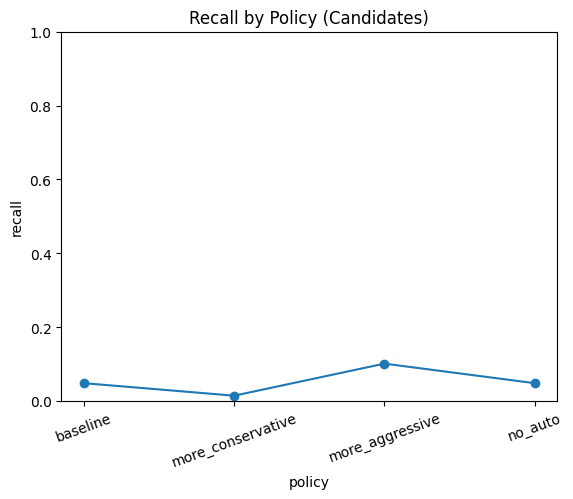

In [18]:
plt.figure()
x = [r["policy"] for r in runs]
plt.bar(x, [r["flagged"] for r in runs])
plt.title("Workload: Flagged Patients by Policy")
plt.xlabel("policy")
plt.ylabel("flagged count")
plt.xticks(rotation=20)
plt.show()

plt.figure()
plt.plot(x, [r["precision"] for r in runs], marker="o")
plt.title("Precision by Policy (Candidates)")
plt.xlabel("policy")
plt.ylabel("precision")
plt.xticks(rotation=20)
plt.ylim(0,1)
plt.show()

plt.figure()
plt.plot(x, [r["recall"] for r in runs], marker="o")
plt.title("Recall by Policy (Candidates)")
plt.xlabel("policy")
plt.ylabel("recall")
plt.xticks(rotation=20)
plt.ylim(0,1)
plt.show()

### 🔎 Checkpoint 8 — Deployment Decision
Which policy would you recommend for an initial pilot? Why?

Consider:
- clinician workload
- missed cases (false negatives)
- unnecessary workups (false positives)
- automation risk

## 9. Online API Calls (Optional, Real)

Online models can help with **human-facing** tasks such as:
- summarizing long notes for clinician review
- generating consistent “patient card” explanations
- proposing clarification questions / threshold suggestions

This section contains **real** API call code that will run **if** your environment is configured.
If it is not configured, the notebook continues using local heuristics **without error**.

**Safety reminder:** never send protected health information (PHI) to an external model without an approved workflow.
In this lab, we only send **synthetic** note text.

In [19]:
# =========================
# 9.1 Online API Setup (Optional)
# =========================
# GreatLearning OpenAI-compatible proxy setup for Colab.
# If key isn't present, ONLINE calls are disabled gracefully.

!pip -q install -U openai

import os
USE_ONLINE_API = True
client = None

# ---- Key retrieval (Colab Secrets preferred) ----
GL_OPENAI_KEY = None
try:
    from google.colab import userdata
    GL_OPENAI_KEY = userdata.get("GL_OpenAI")
except Exception:
    pass

# Optional env fallbacks (helpful outside Colab)
GL_OPENAI_KEY = GL_OPENAI_KEY or os.getenv("GL_OpenAI") or os.getenv("OPENAI_API_KEY")

# ---- Configure client for GreatLearning proxy ----
GL_BASE_URL  = "https://aibe.mygreatlearning.com/openai/v1"
GL_MODEL_ID  = "gpt-4o-mini"   # keep this consistent with what GL supports

if not GL_OPENAI_KEY:
    USE_ONLINE_API = False
    print("ONLINE API disabled: missing key. Set Colab Secret 'GL_OpenAI' or env var GL_OpenAI/OPENAI_API_KEY.")
else:
    try:
        from openai import OpenAI
        client = OpenAI(
            api_key=GL_OPENAI_KEY,
            base_url=GL_BASE_URL,
        )
    except Exception as e:
        USE_ONLINE_API = False
        client = None
        print("ONLINE API disabled: OpenAI client unavailable:", repr(e))

print("USE_ONLINE_API =", USE_ONLINE_API)
print("BASE_URL      =", GL_BASE_URL if USE_ONLINE_API else None)
print("MODEL_ID      =", GL_MODEL_ID if USE_ONLINE_API else None)


USE_ONLINE_API = True
BASE_URL      = https://aibe.mygreatlearning.com/openai/v1
MODEL_ID      = gpt-4o-mini


In [20]:
# =========================
# 9.2 Online helpers
# =========================

def _llm_call(prompt: str, model: str | None = None, temperature: float = 0.2, max_tokens: int = 400) -> str:
    """
    GreatLearning proxy-friendly LLM call.
    Uses Chat Completions for maximum compatibility with OpenAI-compatible gateways.
    """
    if not USE_ONLINE_API or client is None:
        return "[Online API disabled]"

    model = model or GL_MODEL_ID

    try:
        resp = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a careful clinical assistant. Be concise and explicit about uncertainty."},
                {"role": "user", "content": prompt},
            ],
            temperature=temperature,
            max_tokens=max_tokens,
        )
        return resp.choices[0].message.content.strip()

    except Exception as e:
        # Make debugging 400s much easier
        msg = f"[Online API error] {type(e).__name__}: {e}"
        # If the OpenAI SDK includes extra context, it often lives on e.response / e.body
        for attr in ("response", "body"):
            if hasattr(e, attr):
                msg += f"\n  {attr}={getattr(e, attr)}"
        return msg


def llm_summarize_note(note_text: str, model: str | None = None) -> str:
    """Summarize a (synthetic) note for clinician review."""
    prompt = f"""You are assisting a clinician reviewing possible MS risk.
Summarize the note excerpt in 3 bullet points:
- evidence suggestive of demyelinating disease / MS
- plausible alternative explanations
- what missing information would most help next

Be explicit about uncertainty. Keep it concise.

NOTE EXCERPT (synthetic):
{note_text}
"""
    return _llm_call(prompt, model=model, max_tokens=250)


def llm_patient_card_explanation(card: dict, model: str | None = None) -> str:
    """Generate a short, clinician-facing explanation based on a patient card."""
    prompt = f"""You are generating a clinician-facing explanation for an MS risk screening flag.
Given the structured card below, write:
1) a 2–4 sentence explanation of why this patient was flagged
2) 2 recommended next steps
3) 1 caution about over-trusting automation

Card:
{card}
"""
    return _llm_call(prompt, model=model, max_tokens=300)


def llm_propose_thresholds(current_metrics: str, model: str | None = None) -> str:
    """Propose threshold adjustments. Teaching only; must be validated offline."""
    prompt = f"""You are advising on governance thresholds for a simulated MS risk screening system.
Given the evaluation summary below, propose:
- revised thresholds (review, draft, auto)
- a short justification
- 2 risks of changing thresholds too aggressively

Return a compact bullet list.

Evaluation summary:
{current_metrics}
"""
    return _llm_call(prompt, model=model, max_tokens=300)


In [21]:
# =========================
# 9.3 Demo: Run online summarization/explanation on ONE example
# =========================

# Choose a top-risk example from earlier tables
example_pid = top_display.iloc[0]["patient_id"]
card = build_patient_card(example_pid)

print("Patient:", example_pid)
print("Local note excerpt:", card["note_excerpt"])

summary_text = llm_summarize_note(card["note_excerpt"])
print("\n=== LLM Note Summary ===")
print(summary_text)

expl_text = llm_patient_card_explanation(card)
print("\n=== LLM Patient Card Explanation ===")
print(expl_text)

metrics_str = metrics.to_string(index=False)
thresh_text = llm_propose_thresholds(metrics_str)
print("\n=== LLM Threshold Suggestions (Teaching Only) ===")
print(thresh_text)

Patient: P02126
Local note excerpt: MRI brain w/wo contrast ; oligoclonal bands ; periventricular lesions

=== LLM Note Summary ===
- **Evidence Suggestive of Demyelinating Disease/MS**: MRI findings show periventricular lesions and the presence of oligoclonal bands, which are commonly associated with multiple sclerosis.
  
- **Plausible Alternative Explanations**: Other conditions, such as neuromyelitis optica or other inflammatory demyelinating diseases, could also account for the MRI findings and oligoclonal bands.

- **Missing Information for Clarity**: Additional clinical history, including symptom onset, neurological examination results, and follow-up MRI findings, would be most helpful to differentiate between MS and other potential diagnoses. There is uncertainty regarding the specificity of the findings without this context.

=== LLM Patient Card Explanation ===
1) This patient was flagged due to a high risk score of 0.93, indicating a significant likelihood of multiple sclero

### 🔎 Checkpoint 9 — Operational Safety

If you enable online calls in a real hospital system, list **three guardrails** you would require.

Examples:
- data minimization / de-identification
- allowlist of fields that may be sent
- human approval gates and escalation thresholds
- logging + audit trails
- red-team tests for unsafe or biased behavior

## 10. Wrap-Up: What Interaction & Embodiment Changed

You built a multi-agent screening workflow and saw how “embodiment” shows up even in a purely digital setting:

- Workflow constraints shape behavior (time, staffing, consequences)
- Transparency is required for trust calibration
- Adjustable autonomy must be explicit and governed
- Dashboards enable operational decisions (performance + Responsible AI indicators)

### Final Reflection
If this system caused harm, what would be the most likely pathway?
- data issues?
- threshold/policy issues?
- poor explanations?
- over-automation?
- misuse by downstream humans?

Write one paragraph, then propose one mitigation.

## 6C. Candidate Precursors & Structured Markers for MS Screening (with citations)

In practice, “risk screening” often uses **signals that precede diagnosis** or appear in *adjacent workflows*.  
These are not definitive on their own, but they can help *prioritize review* when used responsibly.

Below are examples of markers that commonly appear in EHR data streams:

### A) Standardized clinical pathways & structured testing
- **MS PATHS** is a learning health system that standardizes routine-care data capture, including the **Multiple Sclerosis Performance Test (MSPT)** (quantitative function tests + patient-reported outcomes), and standardized MRI acquisition and quantitative measures.
- In real deployments, **smartform fields** (structured clinician-entered fields) can reduce ambiguity vs free-text notes (at the cost of workflow burden).

### B) Known or suspected risk factors / correlates seen in other disease models
- **Vitamin D**: A substantial body of evidence associates lower serum 25(OH)D with increased MS risk and with MRI/clinical activity; Mendelian randomization supports a causal relationship, though supplementation effects still require careful trial evidence.
- **Modifiable risk factors** frequently discussed in epidemiology include smoking, obesity, infectious mononucleosis (often related to EBV), low vitamin D, and head injury, with evidence that these factors are relevant across diverse backgrounds.
- **EBV (Epstein–Barr virus)** infection has strong epidemiologic evidence associated with increased MS risk (widely discussed following large cohort analyses).

### C) Fairness implications (why we monitor by subgroup)
Markers and pathways can be **unevenly measured** across populations due to access, documentation patterns, and care pathways.  
For example, MS PATHS analyses have been used to study disease severity and socioeconomic status across Black and White Americans with MS.

**Key principle:** subgroup monitoring is not optional; it is required to detect measurement and workflow inequities.

### 🔎 Checkpoint 6C
Pick one marker above (e.g., vitamin D deficiency, EBV history, structured performance testing).  
How could it improve screening? How could it introduce bias or inequity?

### 6C.1 Extension (SIMULATION): Add “precursor marker” fields and compare outcomes

To keep the notebook runnable without external data, we simulate additional EHR-like fields:
- vitamin D level / deficiency
- EBV / infectious mononucleosis history
- a “smartform-like” structured symptom score
- a “PATHS-like” performance score

Then we compare:
- overall performance
- subgroup behavior (selection rate and precision/recall)

> This is simulation for teaching. Real markers require clinical definitions, governance, and validation.

In [22]:
# =========================
# 6C.1 Simulate precursor marker fields (SIMULATION)
# =========================

aug = patients.copy()

# Simulate Vit D (ng/mL): lower on average for higher-risk in this synthetic world
base_vitd = np.clip(np.random.normal(28, 10, size=len(aug)), 5, 80)
risk_influence = 6 * aug["true_at_risk"].astype(int).values  # push lower for at-risk
aug["vitamin_d_ngml"] = np.clip(base_vitd - risk_influence + np.random.normal(0, 3, size=len(aug)), 5, 80)
aug["vitamin_d_deficient"] = (aug["vitamin_d_ngml"] < 20).astype(int)

# EBV / mono history (binary), correlated with risk
aug["infectious_mono_history"] = (np.random.rand(len(aug)) < (0.10 + 0.18*aug["true_at_risk"])).astype(int)

# Smartform-like structured symptom score: compress symptom evidence into a single field
aug["smartform_neuro_symptom_score"] = np.clip(
    aug[SYMPTOMS].sum(axis=1) + np.random.normal(0, 0.75, size=len(aug)),
    0, 8
)

# PATHS-like performance score (lower => worse function), correlated with risk + age
aug["paths_like_function_score"] = np.clip(
    100 - 6*aug["true_at_risk"] - 0.15*aug["age"] + np.random.normal(0, 6, size=len(aug)),
    0, 100
)

aug[["vitamin_d_ngml","vitamin_d_deficient","infectious_mono_history","smartform_neuro_symptom_score","paths_like_function_score"]].head()

,vitamin_d_ngml,vitamin_d_deficient,infectious_mono_history,smartform_neuro_symptom_score,paths_like_function_score
0,34.348623,0,0,0.936872,98.787214
1,46.806496,0,0,0.595620,100.000000
2,22.028951,0,0,0.000000,95.826520
3,26.465815,0,0,0.938057,97.873542
4,23.317192,0,0,1.370569,93.837618


In [23]:
# =========================
# 6C.2 Updated phenotyping model that uses new markers
# =========================

class PhenotypingAgentV2(PhenotypingAgent):
    name = "phenotyping_v2"
    def score(self, row: pd.Series):
        # Start with baseline score + contributions
        base_risk, base_contrib = super().score(row)

        # Add additional markers with small, interpretable contributions
        extra = {
            "vitamin_d_deficient": 0.06 * float(row.get("vitamin_d_deficient", 0)),
            "infectious_mono_history": 0.05 * float(row.get("infectious_mono_history", 0)),
            "smartform_neuro_symptom_score": 0.02 * float(row.get("smartform_neuro_symptom_score", 0)),
            "paths_like_function_score": 0.00,  # lower is worse; we encode via a penalty below
        }

        # Encode worse function as higher risk (in this synthetic demo)
        func = float(row.get("paths_like_function_score", 100))
        extra["paths_like_function_low"] = 0.04 * float(func < 70)

        raw = float(np.clip(base_risk + sum(extra.values()), 0.0, 1.0))
        contrib = dict(base_contrib)
        contrib.update(extra)
        return raw, contrib

phenotype_v2 = PhenotypingAgentV2()

# Re-run workflow quickly on the same candidate set using augmented data
aug_index = aug.set_index("patient_id")

coord_v2 = Coordinator(policy=POLICY)
results_v2 = []

for pid in candidate_ids:
    row = aug_index.loc[pid]
    risk, contrib = phenotype_v2.score(row)
    safety_payload = safety.run(row, risk)
    decision = coord_v2.decide(risk, safety_payload)
    results_v2.append({
        "patient_id": pid,
        "risk_score": risk,
        "action": decision["action"],
        "autonomy_level": decision["autonomy_level"],
        "flag_count": safety_payload["flag_count"],
        "true_at_risk": int(row["true_at_risk"]),
        "sex": row["sex"],
        "age": row["age"],
        "lookalike_dx": row["lookalike_dx"],
        "vitamin_d_deficient": int(row["vitamin_d_deficient"]),
        "infectious_mono_history": int(row["infectious_mono_history"]),
    })

out_v2 = pd.DataFrame(results_v2)

# Compare baseline vs v2
def summarize(df):
    tp, fp, tn, fn = confusion_counts(df)
    return pd.Series({
        "flagged": int((df["action"]!="NO_ACTION").sum()),
        "precision": tp/(tp+fp+1e-9),
        "recall": tp/(tp+fn+1e-9),
        "auto": int((df["autonomy_level"]=="AUTO_ORDER_WITH_GUARDRAILS").sum()),
        "draft": int((df["autonomy_level"]=="DRAFT_ORDER").sum()),
        "recommend": int((df["autonomy_level"]=="RECOMMEND_ONLY").sum()),
    })

comparison = pd.DataFrame({
    "baseline": summarize(out),
    "with_precursor_markers": summarize(out_v2)
})

comparison.style.format("{:.3f}").set_caption("Baseline vs augmented phenotyping (candidate set, simulation)")

,baseline,with_precursor_markers
flagged,38.000,80.000
precision,0.947,0.950
recall,0.049,0.103
auto,1.000,4.000
draft,3.000,13.000
recommend,1378.000,1365.000


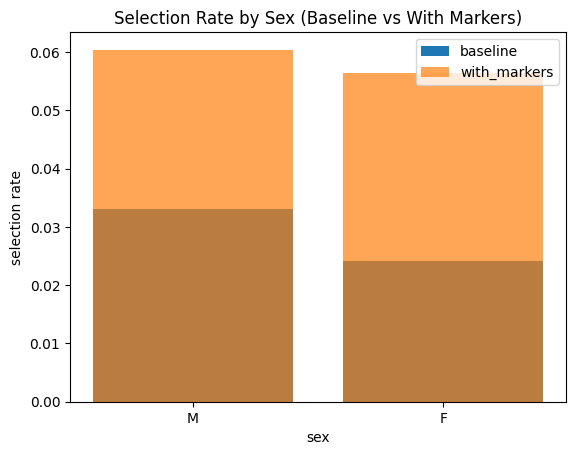

/tmp/ipython-input-3909322832.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return d.groupby(group_col)["flagged"].mean().sort_values(ascending=False)
/tmp/ipython-input-3909322832.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return d.groupby(group_col)["flagged"].mean().sort_values(ascending=False)


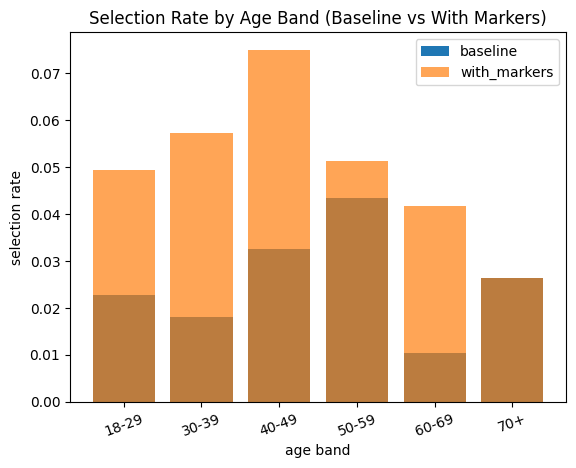

In [24]:
# =========================
# 6C.3 Dashboard: subgroup flag rates for baseline vs augmented
# =========================

def subgroup_flag_rate(df, group_col):
    d = df.copy()
    d["flagged"] = (d["action"]!="NO_ACTION").astype(int)
    return d.groupby(group_col)["flagged"].mean().sort_values(ascending=False)

# Build aligned subgroup frames (sex and age_band)
def add_age_band(df):
    d = df.copy()
    d["age_band"] = pd.cut(d["age"], bins=[17,29,39,49,59,69,90],
                           labels=["18-29","30-39","40-49","50-59","60-69","70+"], include_lowest=True)
    return d

base_sub = add_age_band(out.merge(patients[["patient_id","sex","age","lookalike_dx"]], on="patient_id", how="left"))
v2_sub = add_age_band(out_v2)

# Sex flag rates
sex_rates = pd.DataFrame({
    "baseline": subgroup_flag_rate(base_sub, "sex"),
    "with_markers": subgroup_flag_rate(v2_sub, "sex"),
}).fillna(0)

sex_rates.style.format("{:.3f}").set_caption("Flag (selection) rate by sex (simulation)")

plt.figure()
plt.bar(sex_rates.index, sex_rates["baseline"], label="baseline")
plt.bar(sex_rates.index, sex_rates["with_markers"], label="with_markers", alpha=0.7)
plt.title("Selection Rate by Sex (Baseline vs With Markers)")
plt.xlabel("sex")
plt.ylabel("selection rate")
plt.legend()
plt.show()

# Age-band flag rates
age_rates = pd.DataFrame({
    "baseline": subgroup_flag_rate(base_sub, "age_band"),
    "with_markers": subgroup_flag_rate(v2_sub, "age_band"),
}).fillna(0)

plt.figure()
plt.bar(age_rates.index.astype(str), age_rates["baseline"], label="baseline")
plt.bar(age_rates.index.astype(str), age_rates["with_markers"], label="with_markers", alpha=0.7)
plt.title("Selection Rate by Age Band (Baseline vs With Markers)")
plt.xlabel("age band")
plt.ylabel("selection rate")
plt.xticks(rotation=20)
plt.legend()
plt.show()

### 🔎 Checkpoint 6C.3 — Bias / Measurement

1.   List item
2.   List item


If selection rates shift by subgroup after adding markers, what are plausible explanations?

List one “benign” explanation and one “concerning” explanation.

## References (Full Citations for Teaching)

- Mowry EM, Bermel RA, Williams JR, et al. **Harnessing real-world data to inform decision-making: Multiple Sclerosis Partners Advancing Technology and Health Solutions (MS PATHS).** *Neurology.* 2020.

- Rudick RA, Miller DM, Bethoux F, et al. **The Multiple Sclerosis Performance Test (MSPT): an iPad-based disability assessment tool.** *Neurology.* 2014.

- Fitzgerald KC, Munger KL, Köchert K, et al. **Association of vitamin D levels with disease activity and progression in multiple sclerosis.** *JAMA Neurology.* 2015.

- Gray-Roncal K, Fitzgerald KC, Bermel RA, et al. **Association of neighborhood socioeconomic status with multiple sclerosis disease severity.** *Neurology.* 2021. DOI: **10.1212/WNL.0000000000012362**.

> Note: References are provided for context. This notebook remains a simulated instructional lab and is not medical advice.